# Introduction to Interactive Sessions in the `serc` Partition

For today's tutorial, we will be classifying a large, publicly accessible dataset, [FashionMNIST](https://en.wikipedia.org/wiki/Fashion_MNIST) using a pretrained [ResNet18 classifier](https://arxiv.org/abs/1512.03385) in [Pytorch Lightning](https://lightning.ai/docs/pytorch/stable/).

Today's Learning Goals:
> 1. Import software modules in Sherlock
> 2. Develop and test a GPU enabled classifier in an interactive session
> 3. Review checkpointing basics
> 4. Transfer code pipeline into a script file
> 5. Write an `sbatch` file to run the scripted pipeline
> 6. Schedule your first `serc` batch job with Slurm


### Accessing Sherlock's Modules and Importing Python Packages
In this tutorial, we'll show you how Jupyter Lab can be used in an [Open On Demand session](https://ondemand.sherlock.stanford.edu/pun/sys/dashboard/batch_connect/sessions) within `serc` similarly to how you might use the Jupyter ecosystem on your local machine. When using `serc` on Sherlock, there are some software packages that you don't have to worry about updating and installing onto the HPC system. Instead, Sherlock keeps a [list](https://www.sherlock.stanford.edu/docs/software/list/) of available pre-installed packages that you can import as modules. To deploy a module in your interactive session, add your preselected list of modules to the "Additional Modules section" when you are queuing up your On Demand session. If you want to deploy an additional module once your session has already started, open a Terminal window and type `module load <module-name>`.

Once the appropriate modules are loaded, either before the session or by using Terminal within your session, you can import the packages that you need.

In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import lightning as L
from lightning.pytorch.loggers import CSVLogger
import matplotlib.pyplot as plt

When we queued up our current interactive session, we requested a single GPU and imported the `cuda` module. CUDA is the software that allows us to interact with the GPU that is allocated to our current job. Let's use `cuda` to double check that our system recognizes the GPU and can interact with it.

In [2]:
print(f"GPUs available: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")

GPUs available: 1
  GPU 0: Tesla V100-PCIE-32GB


## Developing and Testing our Analysis Pipeline in PyTorch Lightning

There are many frameworks that you can use in Sherlock to run analyses of all kinds. Here, for an image based deep learning task, we use PyTorch Lightning because it enables easy scaling upwards from the development phase (which we work on in this notebook) to training and inference on large, distributed systems. We'll go through some of the considerations that you might want to keep in mind for when you are booking a job on our systems.

### Define Hyperparameters for Model Training
How you select your hyperparameters for training in any machine learning model, whether for linear regression or a deep and wide transformer architecture, depends strongly on the requirements for your analysis and the limitations of the machines that you are working on.

If you are running GPU enabled pipelines on our systems, we do have some fair share requirements:
> **`serc` COMMUNITY GUIDELINES:** 
> - Please use **only 1-2 GPUs when booking an interactive session**, since these types of sessions are for development purposes.
> - **Interactive sessions should have runtimes of 8 hours or less.**
> - Batch jobs can run for longer (<7 days) and with more GPUs.
> - **Please don't memory limit your GPU jobs.** You will get on our system faster with less requirements, and we offer [consulting](https://sdss-compute-consultation.stanford.edu/) if you would like to make your code more efficient on any of our available machines.

Following are typical hyperparameters. We'll break down each one, and how you can use it during the development stage (which interactive sessions are for) or at the training stage (when it is better to queue up a batch job using Slurm).

**Batch Size:**
The batch size is the number of data instances that your model trains on before updating the weights. This matters because though larger batches require larger amounts of onboard memory on your GPU. So if you have large image tiles (common with satellite imagery), or a table with many columns (common in foundation model training), you will benefit from a smaller batch size, since that will give you more flexibility in the hardware that you can use to train. In most cases, any noise that is induced in the gradients from small batch training can be compensated with training for more epochs. 

In [3]:
BATCH_SIZE = 64

**Epochs:** The epochs are the number of times the entire training set is passed through the model. More epochs mean that the model trains for longer. There are statistical considerations around how many epochs that you should train for, but at the development stage you can just train for a couple of epochs to confirm that you model pipeline runs end to end as expected.

In [4]:
EPOCHS = 2

**Learning Rate:** The learning rate dictates the step size used by your optimizer in training, but doesn't have much implications for your hardware choices, however it does effect your model outcomes!

In [5]:
LR = 1e-3

**Worker Count:** This is the number of CPU processes used to load your data. Here we booked 4 CPUs with our single GPU, so we specify 4 workers. This is a common setup for the development stage, which is when you would be using an interactive session, but you would want to adjust this at training time to speed up your training. We request that you calculate how much memory (i.e. CPU count) is available per GPU in your node, and to please not exceed this count, otherwise it leaves machines sitting idle in `serc`.

In [6]:
NUM_WORKERS = 4

**Output Directory:** Lightning stores information about your model as it trains. This allows you to checkpoint your model, and can be used to optimize the hardware that you select on our systems. If you know that you need many GPUs, you can share across multiple partitions, like `serc` and `gpu` for example, however these partitions have different runtimes allowed for their jobs. Checkpointing allows you to save your model mid-training and build upon the previous training when you queue up another job.

In [7]:
OUTPUT_DIR = "../lightning_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

### Data Loading in PyTorch Lightning

Pytorch Lightning provides a built-in wrapper, called the `LightningDataModule` that will load and unload your data batches from the GPU during training and inference time. Here we build a pipeline that downloads FashionMNIST from PyTorch's datasets, applies any transforms, and splits these data into training and validation sets.

This wrapper relies on some of the hyperparameters specified above, including batch size and worker count. **Remember:** A smaller batch size will prevent GPU memory errors, and choosing a worker count that aligns with your available/requested resources will prevent CPU memory errors.

In [8]:
class CustomDataModule(L.LightningDataModule):
    def __init__(self, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def prepare_data(self):
        # Downloads only once
        datasets.FashionMNIST(root="../data", train=True, download=True)
        datasets.FashionMNIST(root="../data", train=False, download=True)

    def setup(self, stage=None):
        self.train_set = datasets.FashionMNIST(root="../data", train=True,
                                               transform=self.transform)
        self.val_set = datasets.FashionMNIST(root="../data", train=False,
                                             transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size,
                          shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

### Define Pretrained ResNet Model

In this tutorial, we are relying on a pretrained ResNet18 model, which is a predefined model in PyTorch's `torchvision` library. Larger models take more memory, so when choosing a model it is important to take into consideration what resources you intend to use and how you might use these most efficiently with your model choices, like architecture and optimization. We offer [consulting](https://sdss-compute-consultation.stanford.edu/) to help you figure out how to achieve this on our systems, so you can get up and running as soon as possible!

In [9]:
class PretrainedResNet18(L.LightningModule):
    def __init__(self, lr=LR):
        super().__init__()
        self.save_hyperparameters()
        self.model = models.resnet18(weights="IMAGENET1K_V1")
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, 10)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

### Quick Interactive Test of the Training Pipeline

Since we're running in an interactive session, we'll do a quick test that our training pipeline works and runs end to end. We do not recommend doing your full training in an interactive session. PyTorch lightning is built to work nicely with batch jobs in Slurm and your training will happen much more effectively outside all of the wrappers that make an interactive session run. This same thing is true of most publicly available machine learning software packages that are out there, and additionally, running in a job allows you to request more resources for longer!

All that we need for our quick test is defined above, in `EPOCHS`. To do this quick test, we are going to run our pipeline on just two epochs, but afterwards, we'll move this over to a job, and then we can train for longer. 

We start by instantiating our the module that loads our data onto the GPU and the model that we'll be using to train on using the classes for each of these that we wrote above.

In [10]:
data_module = CustomDataModule()
resnet_model = PretrainedResNet18()

PyTorch Lightning also allows us to log metrics about our model like loss and accuracy as we go, so we define a file for these to be stored in.

In [11]:
logger = CSVLogger(save_dir=OUTPUT_DIR, name="logs")

Below we define our iterative trainer that trains the model for the number of epochs that we specified above. There are a few additional choices that we make here to allow flexibility for both the development stage (in this notebook) and for distributed training (that we can queue up in a batch job).

We allow Lightning to detect how many GPUs are available using `devices="auto"`, and then we define a strategy for Lightning to distribute training across multiple GPUs. Since we are in a notebook, we use `ddp_notebook`, but we will need to switch this for a batch job.

In [12]:
trainer = L.Trainer(
    max_epochs=EPOCHS,
    accelerator="auto",         
    devices="auto",
    strategy="ddp_notebook" if torch.cuda.device_count() > 1 else "auto",
    precision="16-mixed" if torch.cuda.is_available() else "32",
    logger=logger,
    deterministic=False,
    log_every_n_steps=50,
    default_root_dir=OUTPUT_DIR
)

/home/users/ellianna/.local/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.12 /share/software/user/open/py-jupyterlab/4.3.2_py ...
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finally we fit our model and validate our results using the `trainer` that we just defined.

In [13]:
trainer.fit(resnet_model, datamodule=data_module)
trainer.validate(resnet_model, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | ResNet           | 11.2 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode




































































































































































































































































































































Epoch 1: 100%|██████████| 938/938 [01:08<00:00, 13.73it/s, v_num=2, val_loss=0.213, val_acc=0.923, train_loss=0.204, train_acc=0.926]

`Trainer.fit` stopped: `max_epochs=2` reached.



poch 1: 100%|██████████| 938/938 [01:09<00:00, 13.55it/s, v_num=2, val_loss=0.213, val_acc=0.923, train_loss=0.204, train_acc=0.926]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



alidation DataLoader 0: 100%|██████████| 157/157 [00:06<00:00, 24.43it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9233999848365784     │
│         val_loss          │    0.21302780508995056    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.21302780508995056, 'val_acc': 0.9233999848365784}]

### The Importance of Checkpointing in an HPC System

We mentioned some of the Community Guidelines above which include run time limits on a variety of jobs. When training on an HPC system it is important to keep in mind that your code will terminate at the end of your requested runtime even if it is still running. As such, it is important to checkpoint your model throughout your training pipeline so that you can reload your weights and continue training if your session ends. 

How often you checkpoint will depend on your training times. For models that take a long time to train, you might want to checkpoint after every epoch (the most that you can checkpoint), for models that train in a short amount of time, like the one shown here, you might want to update your checkpoint much less often. 

Here is how you save a final checkpoint your model in PyTorch lightning.

In [14]:
trainer.save_checkpoint(os.path.join(OUTPUT_DIR, "fashionmnist_resnet18.ckpt"))

After this we'll show an example of batching your job and incorporating the checkpointing into the trainer using PyTorch Lightning's `ModelCheckpoint` callback.

### Visualizing Model Predictions Using Checkpointed Weights

Checkpointing allows you to return to your model outcomes, and make predictions even if you've closed down your job. It also allows you to assess your training progress while in the middle of training or if your session terminated. Here we'll load our checkpointed model weights into the architecture that we defined above, and visualize how well our model is classifying after just two epochs.

In [15]:
ckpt_path = "../lightning_output/fashionmnist_resnet18.ckpt"
resnet_model = PretrainedResNet18.load_from_checkpoint(ckpt_path)
resnet_model.eval()

PretrainedResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

We load our withheld validation data, and evaluate it using our model.

In [16]:
data_module = CustomDataModule()
data_module.setup()
val_loader = data_module.val_dataloader()

images, labels = next(iter(val_loader))

In [17]:
with torch.no_grad():
    preds = resnet_model(images)
    pred_labels = preds.argmax(dim=1)

Now we set up the visualization. Typical vision classifiers output a class number rather than a word, so we'll map the class names onto the numbers.

In [18]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

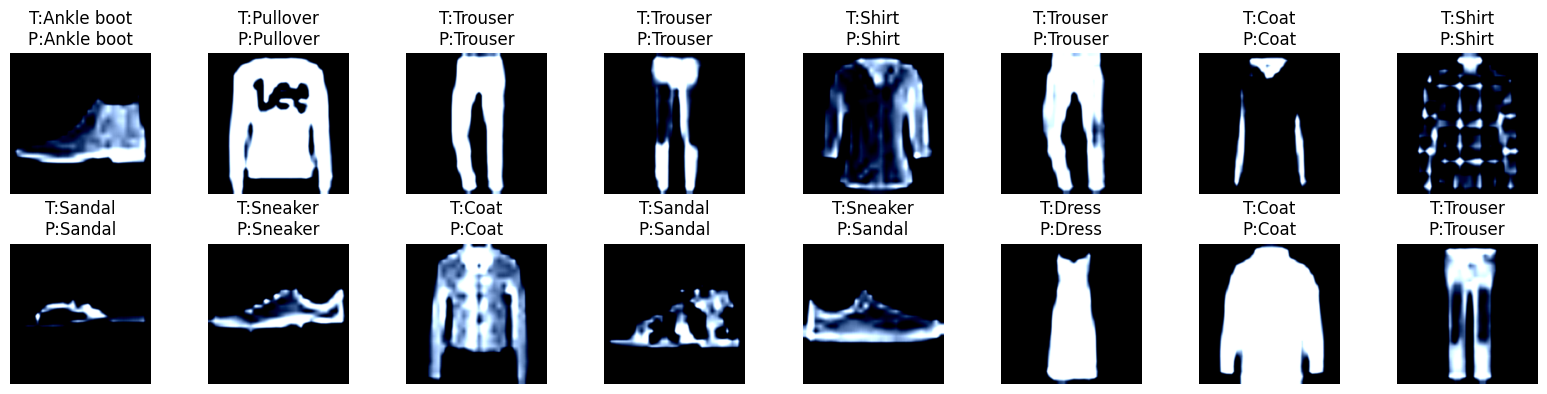

In [19]:
fig, axes = plt.subplots(2, 8, figsize=(16,4))
axes = axes.flatten()
for img, true, pred, ax in zip(images, labels, pred_labels, axes):
    ax.imshow(img.permute(1,2,0).squeeze(), cmap='gray')
    ax.set_title(f"T:{class_names[true]}\nP:{class_names[pred]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

## My Code Works! What Happens if I Want to Train for More Epochs?

Congratulations on building an end-to-end deep learning pipeline that works! This is a great question, and luckily, we have a solution. Now that you have a machine learning pipeline that works end-to-end, let's get it set up to run as a batch job. This is going to require three steps from our learning goals above. Let's walk through them.

### Transfer your Pipeline into a Script File

For the sake of time, we've moved this analysis over into a script file located at `python_scripts/resnet18_pipeline.py` within the [tutorial repo](https://github.com/stanford-sdss/postdoc_onboarding). Please open this file and update the path in `WORK_DIR` to your working directory. Let's quickly go over some of the components that we have changed as we transition from development (in our interactive session) to training (in our batch job).

First, for scripting purposes, we write our entire pipeline into a `main()` function that can be called at runtime. We've written it to make any hyperparameters easily updatable within the final function call, and let's take a closer look at some of the changes that we've made to a couple of our hyparameters.

```python
EPOCHS = 150
NUM_WORKERS = 8
```

Because we are shifting our pipeline out of development mode into the training stage, we are moving over to a batch job. Moving to a batch job also allows us to request a longer runtime and more resources within the Community Guidelines for `serc`. As a result, we can train for more epochs and distribute our pipeline across more workers. In the next section we'll cover a short introduction into picking the right hardware for your setup when requesting resources for your batch job.

We also add checkpointing callbacks into the training loop of our script:
```python
checkpoint_callback = ModelCheckpoint(
    dirpath=output_dir,
    filename="fashionmnist_resnet18_{epoch:03d}",
    save_top_k=-1,  
    every_n_epochs=50
)

...
trainer = L.Trainer(
    ...
    callbacks=[checkpoint_callback],
    ...
)

```

Here we've specified to automatically save a model checkpoint every 50 epochs to our output directory. This is important when running a batch job because the compute is terminated at the end of your runtime, and if your compute is taking longer than expected, checkpointing saves your incremental progress and allows you to continue training from your last save.

### Write an `sbatch` Script to run the Scripted Pipeline

Now that we have a script for our Python pipeline, we need to instruct Sherlock to schedule the hardware specs that we need for our job and to run our script on this hardware. We do this using an `sbatch` file, which is a shell script that tells the system what resources we are requesting for how long and which commands to run. In this tutorial, we have provided you with a sample `sbatch` file, located at `sbatch_scripts/train_resnet18.sh` in the [tutorial repo](https://github.com/stanford-sdss/postdoc_onboarding). Please open this file and update your SUnet ID in line 14 and the path in line 29.

Let's walk through components of the `sbatch` file in parts. On Sherlock, we use a job scheduler called [Slurm](https://slurm.schedmd.com/), and we use the first section of our `sbatch` file to provide directives to Slurm. Slurm has excellent documentation on these flags, and we'll only go through a subset of options today, but you can find their docs [here](https://slurm.schedmd.com/sbatch.html).

One required flag for working on `serc` specifically is the `partition` flag which directs Slurm to schedule our job on the nodes dedicated to the `serc` partition.
```bash
#SBATCH --partition=serc  
```

We'll do a quick review of some other flags here.
```bash
#SBATCH --nodes=1                            
#SBATCH --ntasks=1                           
#SBATCH --cpus-per-task=8                                                           
#SBATCH --gres=gpu:2                         
#SBATCH --time=01:00:00                      
```

`nodes=1`: Most jobs only need 1 compute node, and it's a good idea to specify this, since computing across multiple nodes requires that your code is prepared to distribute your compute in a multi-node fashion. 

`ntasks=1`: This controls the number of processes that we'll be spawning. In Pytorch Lightning, `ntask` should be set to 1 when using a `ddp` distribution strategy. However this can change depending on your software setup.

`cpus-per-task=8`: We also define how many CPUs we'll be booking on the node, since any pipeline that is GPU enabled will typically need CPUs as well. How many CPUs you need will depend on your data, CPU compute, and memory needs. When using a GPU, please calculate the number of CPUs that you need within fair share of both CPU and GPU resources. This becomes necessary because certain requests can cause resources to be idle, even if you didn't request them. For example, if you are requesting a GPU on of our A100 nodes that has 8 GPUs/node, this node has 16 CPUs/GPU. If you request 1 GPU, but 128 CPUs that books at the entire node's CPU compute and prevents other researchers from accessing the now idle GPUs there. [Here](https://stanford-rc.github.io/docs-earth/docs/serc_resources#selecting-hardware) is a more in-depth look at selecting resources.

`gres=gpu:2`: This is how you book GPU resources. Since you are running a batch job, you can request more GPUs here than in an interactive session according to our Community Guidelines. Please use the minimum amount of GPUs that you need for your task, and no more than 8 at one time.

`time=01:00:00`: We use this flag to specify our runtime, and it follows the HH:MM:SS convention. It's helpful to run a small test job to calculate how much total time you might need and then to add on a 15% safety margin. `serc` has a runtime limitation of 7 days when running a batch job, but we request that you use the minimal amount of time that you need for fair share. Helpful tip! Include checkpointing inside your training pipeline so that you don't lose any progress if your runtime ends before your code is finished running.

### Scheduling Your First `serc` Batch Job with Slurm

Now that you have your pipeline developed, tested, and scripted, and your `sbatch` file scripted up, you are ready to run your first job!

Head over to the command line. We'll do this by pulling up an interactive shell, but you can also run this from your own terminal using `ssh <sunet-id>@login.sherlock.stanford.edu` and following the login instructions there.

Once you're at the command line type in:
```shell
sbatch <file-name>.sh
```
and you've submitted your job. Congrats!

The command line will print out `Submitted batch job <job-id>`, which corresponds to a unique job ID for your submitted job. If you added email flags to your `sbatch` file, you'll get emails at the specified times.

You can also check on your job's status from the command line, using the following command:
```shell
squeue -j <job-id>
```

Your job will run in the background, so you don't need to worry about staying logged into Sherlock. If you find that you have any questions while you're getting started on `serc`, or if you would like to consult with us on making your workflows run more smoothly on our systems, please don't hesitate to reach out to us at [sdss-compute@stanford.edu](mailto:sdss-compute@stanford.edu) or schedule an appointment with our team [here](https://sdss-compute-consultation.stanford.edu/). Welcome to Stanford!